In [8]:
# #loading libraries
suppressMessages(library(DESeq2))
suppressMessages(library(edgeR))
suppressMessages(library(lubridate))
suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(gsheet))
suppressMessages(library(data.table))
suppressMessages(library(vegan))
suppressMessages(library(EnvStats))
suppressMessages(library(stringr))
suppressMessages(library(ggrepel))

In [9]:
#sessionInfo()
# this code was used for the Differential expression analysis reported in figure 2
# you will need to specify correct paths for files

In [4]:
setwd("/workdir/omm35/paper_urine_cfrna")
source("/workdir/omm35/paper_urine_cfrna/scripts/theme_ggplot_cfrna.R")

In [5]:
sample_key = fread("/workdir/omm35/paper_urine_cfrna/metadata/gvhd_plasma_urine_key.tsv")

sample_key = sample_key  %>% filter(use_pair=="TRUE")






sample_key_urine = sample_key  
sample_key_plasma = sample_key


# #For urine
sample_key_urine$sample_id = sample_key_urine$sample_id_urine

sample_key_urine = column_to_rownames(sample_key_urine, var = "sample_id_urine")
sample_key_urine$event_sym = factor(sample_key_urine$event_sym)

# #For plasma

sample_key_plasma$sample_id = sample_key_plasma$sample_id_plasma
sample_key_plasma = column_to_rownames(sample_key_plasma, var = "sample_id_plasma")
sample_key_plasma$event_sym = factor(sample_key_plasma$event_sym)



######
samples_after_qc = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")
sample_key_urine = sample_key_urine  %>% filter(rownames(sample_key_urine)  %in% samples_after_qc$sample_id)
sample_key_plasma = sample_key_plasma  %>% filter(rownames(sample_key_plasma)  %in% samples_after_qc$sample_id)
######

In [7]:
# table(sample_key_urine$event_sym)


In [6]:
length(unique(sample_key_plasma$Record_ID))
unique(sample_key_plasma$Record_ID)

In [11]:
get_DE <- function(path_to_counts,reference,treatment,sample_key){
    sample_key = sample_key  %>% filter(event_sym==reference | event_sym==treatment)


    
    counts = fread(path_to_counts, header=TRUE)
    counts = column_to_rownames(counts, var = "geneID")
    ##selecting columns matching the samples
    counts = counts %>% dplyr::select(one_of(sample_key$sample_id))
    print(dim(counts))

    dds <- DESeqDataSetFromMatrix(countData = counts,
    colData = sample_key,
    design = ~ SubjectID + event_sym)
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep,]
    dds$event_sym <- factor(dds$event_sym, levels = c(reference,treatment))
    print(levels(dds$event_sym))
    dds <- DESeq(dds)
    
#     res <- results(dds,alpha=0.05, contrast = c("expGroup",GROUPS))
# GROUPS = c("PR","1M")

    res <- results(dds, alpha=0.05,contrast=c("event_sym",reference,treatment))
    res= as.data.frame(res)
    res = rownames_to_column(res)
    colnames(res)[1]="gene_id"

    #loading gene key: for changing gene names
    gene_key = fread("/workdir/omm35/urine_cfRNA_analysis/gencode.biotype.name.key.tsv")
    gene_key = gene_key  %>% dplyr::select(gene_id, gene_name)
    
    #------------
    res  <- res  %>% left_join(gene_key, by ="gene_id")
    rownames(res)= res$gene_id
    res = res[,-1]
    length(unique(res$gene_id))
    res$events = paste0(c(treatment,reference), collapse="-Vs-")
    head(res)

#     res <- results(dds, alpha=0.05)
    resSig <- subset(res, padj < 0.05)    

}

In [1]:
#For urine cfRNA
path_to_counts <- "/local/workdir/omm35/takara_human_V2/output/GVHD/GVHD_feature_counts.tsv"
treatment = c("3M")

#treatment = c("PR","E","1M","2M","3M","6M")
de_df = data.frame()
for (i in 1:length(treatment)){
    
    df = get_DE(path_to_counts,reference="6M",treatment[i],sample_key_urine)
    de_df = rbind(de_df,df)
}
de_urine = de_df 

In [2]:
# #For Plasma
path_to_counts <- "/workdir/omm35/test_cfrna_deconvolution/from_conor/gvhd_hct_feature_counts.tsv"
treatment = c("6M")
#treatment = c("PR","E","1M","2M","3M","6M")
de_df = data.frame()
for (i in 1:length(treatment)){
    
    df = get_DE(path_to_counts,reference="E",treatment[i],sample_key_plasma)
    de_df = rbind(de_df,df)
}
de_plasma = de_df 

In [9]:
comparison=unique(de_plasma$events)
for(i in 1:length(de_plasma)){
    df = de_plasma %>% filter(events==comparison[i]) %>% select(gene_name,log2FoldChange,padj)
    row.names(df)<-NULL
    write_csv(df,paste0("/workdir/omm35/paper_urine_cfrna/DE_for_IPA/",comparison[i],"_plasma.csv"))
}

In [10]:
comparison=unique(de_urine$events)
for(i in 1:length(de_urine)){
    df = de_urine %>% filter(events==comparison[i]) %>% select(gene_name,log2FoldChange,padj)
    row.names(df)<-NULL
    write_csv(df,paste0("/workdir/omm35/paper_urine_cfrna/DE_for_IPA/",comparison[i],"_urine.csv"))
}

In [15]:
#use this to save your dataframes
de_plasma$biofluid="plasma-cfRNA"
de_urine$biofluid="urine-cfRNA"
combined_df = rbind(de_urine,de_plasma)
write_csv(combined_df,"/workdir/omm35/paper_urine_cfrna/DE_for_IPA/DE_genes_urine_and_plasma_2.csv")

[1] "D0-Vs-PR"
[1] "E-Vs-D0"


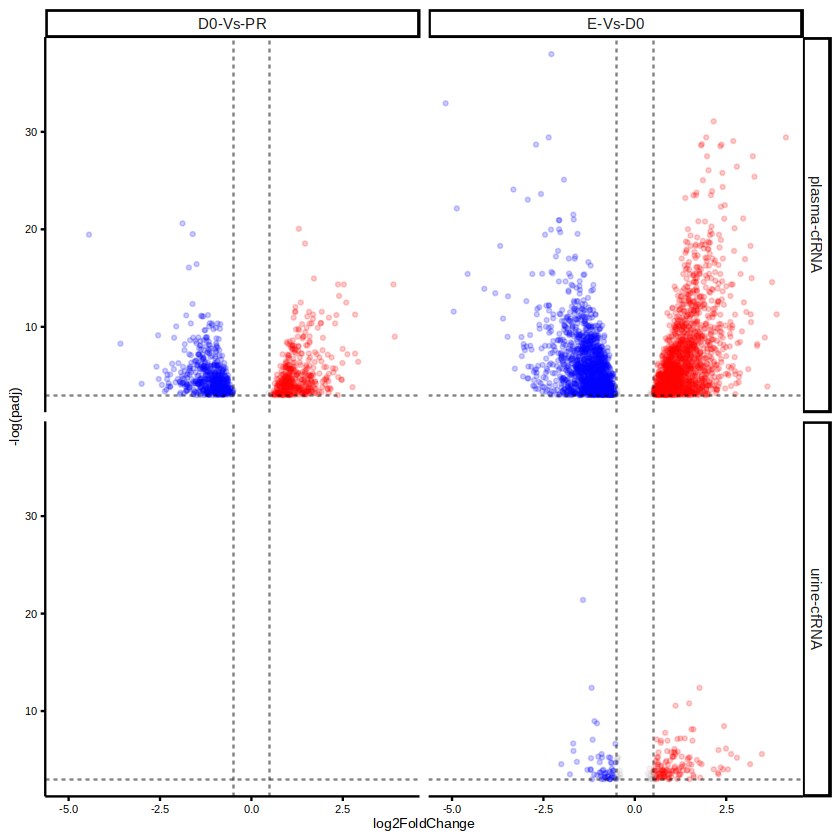

In [70]:
df1=fread("/workdir/omm35/paper_urine_cfrna/DE_for_IPA/DE_genes_urine_and_plasma_1.csv")
df2=fread("/workdir/omm35/paper_urine_cfrna/DE_for_IPA/DE_genes_urine_and_plasma_2.csv")
combined_df=rbind(df1,df2)
combined_df = combined_df %>% filter(events!="E-Vs-PR")
res_df=combined_df
detable = res_df  %>%
    filter(!is.na(padj)) %>% 
    mutate(sig_dir = ifelse(padj<0.05 & log2FoldChange>0.5,"up",
                            ifelse(padj<0.05 & log2FoldChange < -0.5,"down","notsig"))) %>%
    mutate(delabel = ifelse( (sig_dir=="down" & -log(padj) > 15 | log2FoldChange < -2) | (sig_dir=="up" & (-log(padj) > 30 | log2FoldChange > 3) ), gene_name,""))
    
# create plot
detable %>% 
    filter(!is.na(padj)) %>%
    ggplot(aes(x=log2FoldChange, y=-log(padj), color = sig_dir, label=delabel)) + #
    geom_point(size = 0.75, alpha=0.2) +
    geom_hline(yintercept = -log(0.05), size = 0.5, alpha = 0.5, linetype="dashed")+
    geom_vline(xintercept = c(-0.5, 0.5), size = 0.5, alpha = 0.5, linetype="dashed") + 
#    geom_text_repel(size = 4) +
    scale_color_manual(values = c("notsig"="grey","up"="red","down"="blue"))+
    theme_cfrna_paper() +  facet_grid(biofluid~events)





detable = res_df  %>%
    filter(!is.na(padj)) %>% 
    mutate(regulation = ifelse(padj<0.05 & log2FoldChange>0.5,"up",
                            ifelse(padj<0.05 & log2FoldChange < -0.5,"down","notsig")))
sig_genes_only = detable %>% filter(regulation!="notsig")


## this datafrema is only created as a placeholder for easy upset plot plotting

ph_df = sig_genes_only  %>% filter(events=="D0-Vs-PR" & regulation=="up")
ph_df$biofluid = "urine-cfRNA"
ph_df$gene_name="place_holder"
ph_df$gene_name[2]="KCNAB2"

sig_genes_only = rbind(sig_genes_only,ph_df)
########



###
my_palette <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288", "#AA4499", 
                         "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")
comp_groups=unique(sig_genes_only$events)
expression=unique(sig_genes_only$regulation)
for (i in 1:length(comp_groups)){
    print(comp_groups[i])
    for (j in 1:length(expression)){
        
        df = sig_genes_only %>% filter(events==comp_groups[i] & regulation==expression[j])
        if(nrow(df[df$biofluid=="urine-cfRNA"]) != 0){
        genes = unique(df$gene_name)
        data <- data.frame(
        Gene = genes,
        Urine_cf_RNA = as.integer(genes %in% df[df$biofluid=="urine-cfRNA"]$gene_name),
        Plasma_cf_RNA = as.integer(genes %in% df[df$biofluid=="plasma-cfRNA"]$gene_name)
        )
    upset_plot = UpSetR::upset(data, main.bar.color = my_palette[i], sets.bar.color = "lightgray", order.by = "freq",
                               sets.x.label=6)
    pdf(paste0("/workdir/omm35/paper_urine_cfrna/figures/figure_2/",comp_groups[i],"_",expression[j],"_upset_plot.pdf"), 
    width = 2.3, height =2)
    print(upset_plot)
    dev.off()
            }
    }
}

In [3]:
df1=fread("/workdir/omm35/paper_urine_cfrna/DE_for_IPA/D0-Vs-PR.csv")
df1 = df1  %>% mutate(sig_dir = ifelse(padj<0.05 & log2FoldChange>0.5,"up",
                            ifelse(padj<0.05 & log2FoldChange < -0.5,"down","notsig")))
table(df1$sig_dir)

In [21]:
detable = res_df  %>%
    filter(!is.na(padj)) %>% 
    mutate(regulation = ifelse(padj<0.05 & log2FoldChange>0.5,"up",
                            ifelse(padj<0.05 & log2FoldChange < -0.5,"down","notsig")))

In [5]:
###
my_palette <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288", "#AA4499", 
                         "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")
comp_groups=unique(sig_genes_only$events)
expression=unique(sig_genes_only$regulation)
for (i in 1:length(comp_groups)){
    print(comp_groups[i])
    for (j in 1:length(expression)){
        
        df = sig_genes_only %>% filter(events==comp_groups[i] & regulation==expression[j])
        if(nrow(df[df$biofluid=="urine-cfRNA"]) != 0){
        genes = unique(df$gene_name)
        data <- data.frame(
        Gene = genes,
        Urine_cf_RNA = as.integer(genes %in% df[df$biofluid=="urine-cfRNA"]$gene_name),
        Plasma_cf_RNA = as.integer(genes %in% df[df$biofluid=="plasma-cfRNA"]$gene_name)
        )
    upset_plot = UpSetR::upset(data, main.bar.color = my_palette[i], sets.bar.color = "lightgray", order.by = "freq",
                               sets.x.label=6)
    pdf(paste0("/workdir/omm35/paper_urine_cfrna/figures/figure_2/",comp_groups[i],"_",expression[j],"_upset_plot.pdf"), 
    width = 2.3, height =2)
    print(upset_plot)
    dev.off()
            }
    }
}

In [4]:
###
my_palette <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288", "#AA4499", 
                         "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")
comp_groups=unique(sig_genes_only$events)
expression=unique(sig_genes_only$regulation)
for (i in 1:length(events)){
    print(comp_groups[i])
    for (j in 1:length(expression)){
        
        df = sig_genes_only %>% filter(events==comp_groups[i] & regulation==expression[j])
        if(nrow(df[df$biofluid=="urine-cfRNA"]) != 0){
        genes = unique(df$gene_name)
        data <- data.frame(
        Gene = genes,
        Urine_cf_RNA = as.integer(genes %in% df[df$biofluid=="urine-cfRNA"]$gene_name),
        Plasma_cf_RNA = as.integer(genes %in% df[df$biofluid=="plasma-cfRNA"]$gene_name)
        )
    upset_plot = UpSetR::upset(data, main.bar.color = my_palette[i], sets.bar.color = "lightgray", order.by = "freq",
                               sets.x.label=6)
    pdf(paste0("/workdir/omm35/paper_urine_cfrna/figures/figure_2/",events[i],"_",expression[j],"_upset_plot.pdf"), 
    width = 2.5, height =2)
    print(upset_plot)
    dev.off()
            }
    }
}

In [128]:
df = combined_df  %>% filter(events=="E-Vs-PR" & regulation=="Up")
genes = unique(df$gene_name)

data <- data.frame(
Gene = genes,
Urine_cf_RNA = as.integer(genes %in% df[df$biofluid=="urine-cfRNA"]$gene_name),
Plasma_cf_RNA = as.integer(genes %in% df[df$biofluid=="plasma-cfRNA"]$gene_name)
)
UpSetR::upset(data, main.bar.color = "skyblue", sets.bar.color = "lightgray", order.by = "freq")